[![Open in nbviewer](https://img.shields.io/badge/Open%20in%20nbviewer-blue)](PASTE_YOUR_NBVIEWER_LINK_HERE)


#### Diffusion Model 
Diffusion model with variational Autoencoder. With the help of data augmentation, increasing the number of trainable datapoint.  

This notebook contains the same diffusion model as of [this one](https://github.com/raj2022/SSI_Projects/blob/main/project_SSI/Diffusion_model_%232.1.ipynb) and [this one as well](https://github.com/raj2022/SSI_Projects/blob/main/project_SSI/Diffusion_model_%232.ipynb) with a bit change in the architecture. 

In [ ]:
# # To use the CPU only
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Use CPU only

In [10]:
# Required packages
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
## Import Required Libraries for data Generator 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# To clear out the gpu memory
import tensorflow as tf
tf.keras.backend.clear_session()

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [3]:
# list out all the number of GPUs available on the systtem
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
# Load and preprocess data (replace with your own data loading)
fileIN = '../jet_notebooks/Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN)
# Load and preprocess data (replace with your data loading)
# Assuming you have jet images in a numpy array 'jet_images'
# Normalize the pixel values between 0 and 1
jet_images = np.array(f.get('jetImage')).astype('float32') / 255.0
dataset_shape = jet_images.shape
image_size = dataset_shape[1]

In [5]:
# Data Augmentation
# Create Data Generators:
# Define data augmentation settings
data_augmentation = ImageDataGenerator(
    rotation_range=90,      # Random rotation between -20 and 20 degrees
    width_shift_range=0.1,  # Random horizontal shift by 10% of image width
    height_shift_range=0.1, # Random vertical shift by 10% of image height
    shear_range=0.2,        # Random shear transformation
    zoom_range=0.6,         # Random zoom between 80% and 120% of original size
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill newly created pixels with nearest neighbors
)



In [6]:
# Add noise to the images
noise_factor = 0.6
noisy_jet_images = jet_images + noise_factor * np.random.normal(size=jet_images.shape)


In [30]:
# Reshape the jet images dataset to match the model's input shape
jet_images_reshaped = jet_images.reshape((-1, image_size * image_size))
noisy_jet_images_reshaped = noisy_jet_images.reshape((-1, image_size, image_size, 1))


In [31]:
# Create data generators for noisy and clean images
batch_size = 32
train_noisy_datagen = data_augmentation.flow(noisy_jet_images_reshaped, batch_size=batch_size, shuffle=True)
train_clean_datagen = data_augmentation.flow(jet_images_reshaped, batch_size=batch_size, shuffle=True)


ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (10000, 10000))

###  Issues:
    1. Validation loss falls sharply while the training loss falls smoothly. 
---
    -> Trying to reduce the model complexity
    2. There are another methods which we can implement:
        1. Reduce Model Complexity: 
        2. Regularization Techniques
        3. Data Augmentation
        4. Early Stopping
        5. Validation Data
        6. Learning Rate Schedule
        7. Different Architecture
        8. More Datas
        9. Batch Normalization
        10. Early Stopping

In [32]:
# Define the new architecture
input_img = Input(shape=(image_size, image_size, 1))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(image_size * image_size, activation='sigmoid')(x)


In [33]:
autoencoder = Model(input_img, output)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')


In [34]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 100, 100, 8)       80        
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 50, 50, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 50, 50, 16)        1168      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 25, 25, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 25, 25, 32)        4640

In [35]:
# # Train the autoencoder
# history = autoencoder.fit(noisy_jet_images_reshaped, jet_images_reshaped,
#                           epochs=5,
#                           batch_size=64,
#                           shuffle=True,
#                           validation_split=0.1)


In [36]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [37]:
# Training the autoencoder with the genrated data or the augmented data
history = autoencoder.fit_generator(
    zip(train_noisy_datagen, train_clean_datagen),
    steps_per_epoch=len(noisy_jet_images_reshaped) // batch_size,
    epochs=50,
    validation_data=(noisy_jet_images_reshaped, jet_images_reshaped), 
    callbacks=[early_stopping]
)


Epoch 1/50


/tmp/sraj/ipykernel_455019/2041531694.py:2: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(


ValueError: A target array with shape (32, 100, 100, 1) was passed for an output of shape (None, 10000) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.

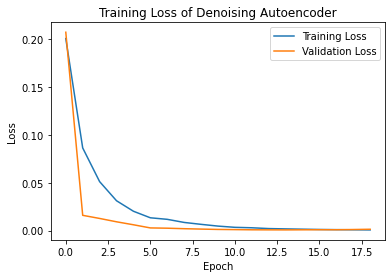

In [15]:
# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of Denoising Autoencoder')
plt.legend()
plt.show()

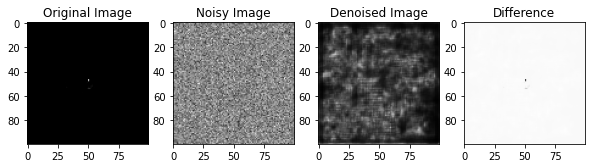

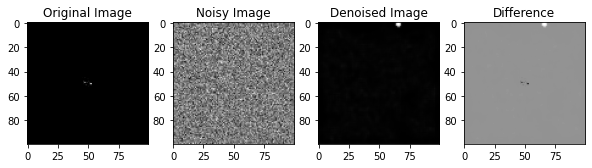

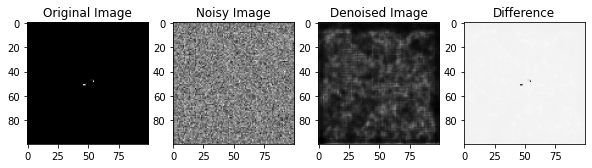

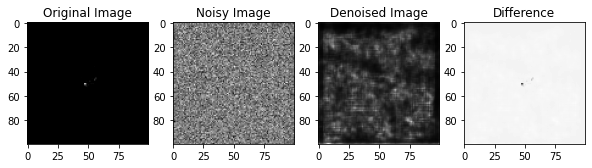

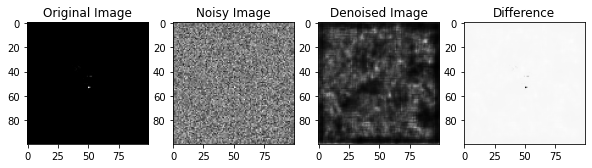

In [17]:

# Denoise some sample images
num_samples = 5
sample_indices = np.random.randint(0, len(noisy_jet_images_reshaped), num_samples)
sample_noisy_images = noisy_jet_images_reshaped[sample_indices]
sample_denoised_images = autoencoder.predict(sample_noisy_images)

# Display original, noisy, and denoised images
for i in range(num_samples):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(jet_images_reshaped[sample_indices[i]].reshape((image_size, image_size)), cmap='gray')
    plt.title('Original Image')
    
    plt.subplot(1, 4, 2)
    plt.imshow(noisy_jet_images_reshaped[sample_indices[i]].reshape((image_size, image_size)), cmap='gray')
    plt.title('Noisy Image')
    
    plt.subplot(1, 4, 3)
    plt.imshow(sample_denoised_images[i].reshape((image_size, image_size)), cmap='gray')
    plt.title('Denoised Image')
    
    plt.subplot(1, 4, 4)
    plt.imshow(sample_denoised_images[i].reshape((image_size, image_size)) - 
               jet_images_reshaped[sample_indices[i]].reshape((image_size, image_size)), cmap='gray')
    plt.title('Difference')
    
    plt.show()

Adding colorbar to the above image

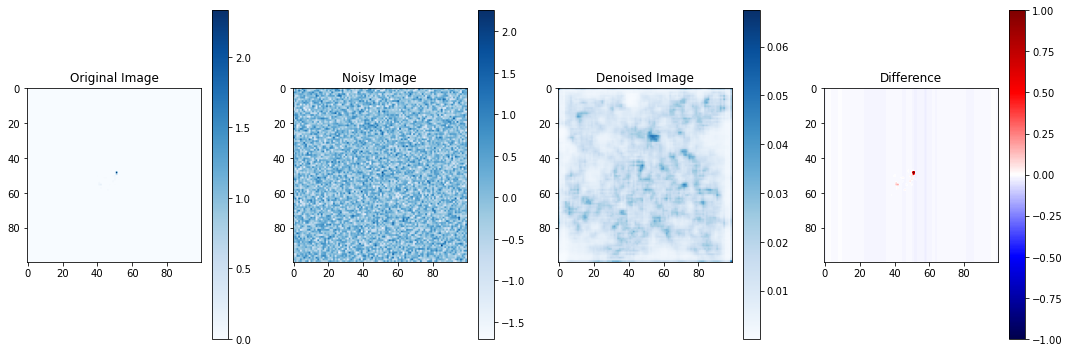

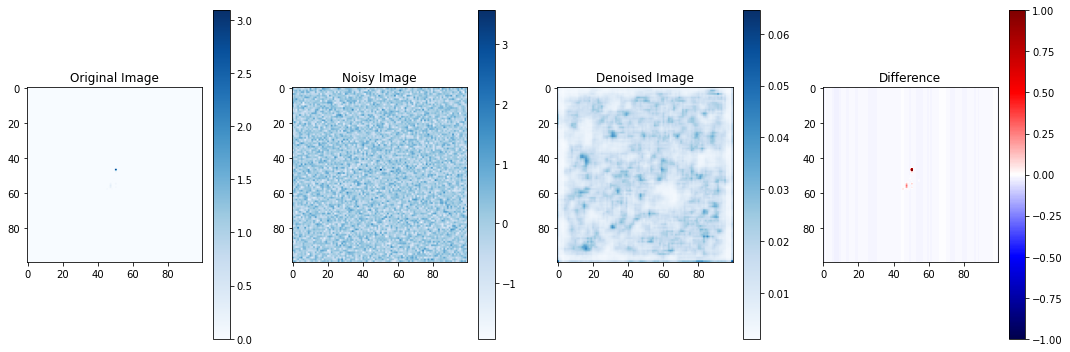

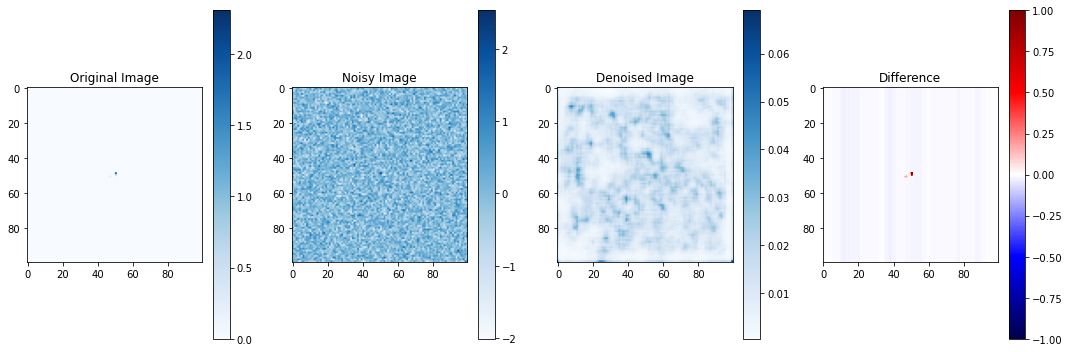

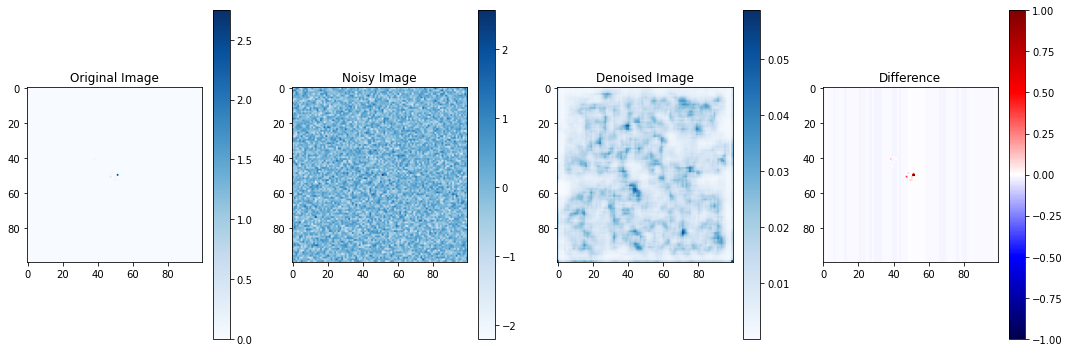

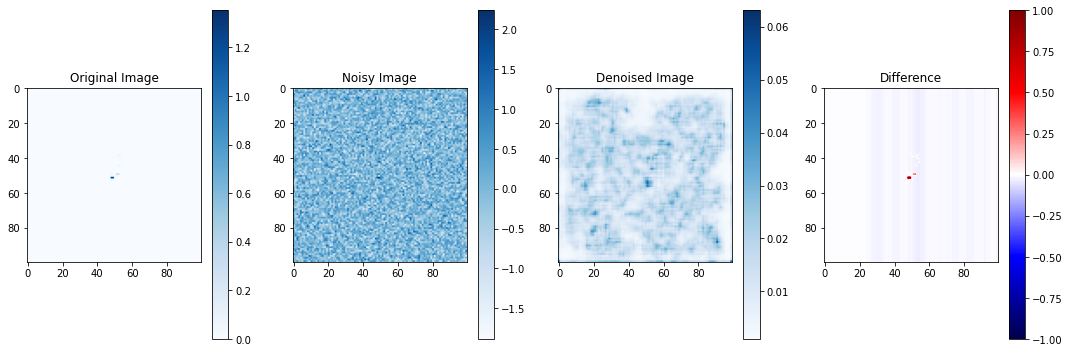

In [23]:

# Denoise some sample images. 
num_samples = 5
sample_indices = np.random.randint(0, len(noisy_jet_images_reshaped), num_samples)
sample_noisy_images = noisy_jet_images_reshaped[sample_indices]
sample_denoised_images = autoencoder.predict(sample_noisy_images)

# Display original, noisy, denoised images, and difference with custom colormap
for i in range(num_samples):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(jet_images_reshaped[sample_indices[i]].reshape((image_size, image_size)), cmap='Blues')
    plt.title('Original Image')
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.imshow(noisy_jet_images_reshaped[sample_indices[i]].reshape((image_size, image_size)), cmap='Blues')
    plt.title('Noisy Image')
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.imshow(sample_denoised_images[i].reshape((image_size, image_size)), cmap='Blues')
    plt.title('Denoised Image')
    plt.colorbar()

    plt.subplot(1, 4, 4)
    # Calculate the difference between original and denoised images
    difference = jet_images_reshaped[sample_indices[i]] - sample_denoised_images[i].reshape((image_size, image_size))
    # Display a specific slice of the difference array (e.g., the middle slice)
    middle_slice = difference[:,:,difference.shape[2]//2]
    plt.imshow(middle_slice, cmap='seismic', vmin=-1, vmax=1)  # Customizing the colormap and range
    plt.title('Difference')
    plt.colorbar()

    plt.tight_layout()
    plt.show()